In [12]:
import gymnasium as gym
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
import random
import matplotlib.pyplot as plt

# 0. Q-Learning

In [2]:
env = gym.make("FrozenLake-v1", is_slippery=False)

# parameters
alpha = 0.1
gamma = 0.6

# Set the action and state space sizes
n_actions = env.action_space.n
n_states = env.observation_space.n

# init Q-table with zeros
Q = np.zeros((n_states, n_actions))

# set number of num_episodes
num_episodes = 10_000

# list for storing rewards for each episode
r_list = []

# num_episodes
for i in range(num_episodes):

  # reset the env and get the initial state
  state = env.reset()[0]
  r_all = 0
  done = False

  # The Q-Table learning algorithm
  while not done:

    # choose an actoin by greedily (with noise) picking from Q table
    # Assume initial state values are known then choose first max value
    # from the current state -> next state 
    action = np.argmax(Q[state,:] + np.random.randn(1, n_actions) / (i+1))

    # get new state and reward from env
    new_state, reward, done, _, _ = env.step(action)

    # update Q-Table with new knowledge
    Q[state, action] = Q[state, action] + alpha * (reward + 
                        gamma * np.max(Q[new_state, :]) - Q[state, action])
    
    # update total reward
    r_all += reward
    
    # set new state
    state = new_state

  # append total reward for this episode to the reward list
  r_list.append(r_all)

print("Score over time: " + str(sum(r_list) / num_episodes))
print("Final Q-Table values: ")
print(Q)
print(f"Mean of Q-Table: {np.mean(Q)}")

Score over time: 0.9825
Final Q-Table values: 
[[2.09890376e-03 7.77600000e-02 8.07243903e-04 1.16487568e-03]
 [6.09776555e-04 0.00000000e+00 1.56928467e-03 6.53387906e-04]
 [2.98588239e-04 6.24259675e-03 4.92024466e-05 6.60776969e-04]
 [2.69765226e-04 0.00000000e+00 4.81574751e-05 2.34408818e-05]
 [4.60309287e-04 1.29600000e-01 0.00000000e+00 2.58725287e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.77359574e-02 0.00000000e+00 1.44739872e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.50578083e-04 0.00000000e+00 2.16000000e-01 2.99225718e-05]
 [2.25632675e-05 2.46240000e-06 3.60000000e-01 0.00000000e+00]
 [0.00000000e+00 6.00000000e-01 0.00000000e+00 2.16000000e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.29600000e-06 2.81135400e-02 2.16000000e-05]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.0000

## 0.1 Simulating the Policy

In [3]:
# ------- Simulating the Policy --------
policy = {}
for i, act in enumerate(np.argmax(Q, axis=1)):
  policy[i] = act

print("Policy: ", policy)

path = []
dirs = ['left', 'down', 'right', 'up']

state = env.reset()[0]
r_all = 0
done = False

while not done:
  # Choose an action by greedily (with noise) picking from Q table
  action = np.argmax(Q[state,:])
  path.append(dirs[action])

  # Get new state and reward from environment
  new_state, reward, done, _, _ = env.step(action)

  # update total reward
  r_all += reward

  # set new state
  state = new_state

print("Path: ", path)
print("Reward: ", reward)

Policy:  {0: np.int64(1), 1: np.int64(2), 2: np.int64(1), 3: np.int64(0), 4: np.int64(1), 5: np.int64(0), 6: np.int64(1), 7: np.int64(0), 8: np.int64(2), 9: np.int64(2), 10: np.int64(1), 11: np.int64(0), 12: np.int64(0), 13: np.int64(2), 14: np.int64(2), 15: np.int64(0)}
Path:  ['down', 'down', 'right', 'right', 'down', 'right']
Reward:  1.0


# 1. Deep Q Network

In [4]:
# Linear DQN Network which tries to learn the approximation of value function
class LinearDeepQNetwork(nn.Module):
  def __init__(self, lr, n_actions, input_dims):
    super(LinearDeepQNetwork, self).__init__()

    self.fc1 = nn.Linear(*input_dims, 128)
    self.fc2 = nn.Linear(128, n_actions)

    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')

    # entire network to the device
    self.to(self.device)

  def forward(self, state):
    layer1 = F.relu(self.fc1(state))
    actions = self.fc2(layer1)

    return actions

In [5]:
class Agent():
  def __init__(self, input_dims, n_actions, lr, gamma=0.99,
               epsilon=1.0, eps_dec=1e-5, eps_min=0.01):
    self.lr = lr
    self.input_dims = input_dims
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_dec = eps_dec
    self.eps_min = eps_min
    self.action_space = [i for i in range(self.n_actions)]
    
    self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

  def choose_action(self, observation):
    if np.random.random() > self.epsilon:
      state = T.tensor(observation, dtype=T.float).to(self.Q.device)
      actions = self.Q.forward(state)
      action = T.argmax(actions).item()
    else:
      action = np.random.choice(self.action_space)

    return action

  def decrement_epsilon(self):
    self.epsilon = self.epsilon - self.eps_dec \
                    if self.epsilon > self.eps_min else self.eps_min
    
  def learn(self, state, action, reward, state_):
    self.Q.optimizer.zero_grad()

    states = T.tensor(state, dtype=T.float).to(self.Q.device)
    actions = T.tensor(action).to(self.Q.device)
    rewards = T.tensor(reward).to(self.Q.device)
    states_ = T.tensor(state_, dtype=T.float).to(self.Q.device)

    q_pred = self.Q.forward(states)[actions]

    q_next = self.Q.forward(states_).max()

    q_target = reward + self.gamma * q_next

    loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
    loss.backward()
    self.Q.optimizer.step()
    self.decrement_epsilon()


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(x, scores, epsilons, filename):
  fig = plt.figure()
  ax = fig.add_subplot(111, label="1")
  ax2 = fig.add_subplot(111, label="2", frame_on=False)

  ax.plot(x, epsilons, color="C0")
  ax.set_xlabel("Training Steps", color="C0")
  ax.set_ylabel("Epsilon", color="C0")
  ax.tick_params(axis='x', colors="C0")
  ax.tick_params(axis='y', colors="C0")

  N = len(scores)
  running_avg = np.Empty(N)
  for t in range(N):
    running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])

  ax2.scatter(x, running_avg, color="C1")
  ax2.axes.get_xaxis().set_visible(False)
  ax2.yaxis.tick_right()
  ax2.set_ylabel('Score', color="C1")
  ax2.yaxis.set_label_position('right')
  ax2.tick_params(axis='y', colors="C1")

  plt.savefig(filename)

In [7]:
env = gym.make('CartPole-v1')
n_games = 10000
scores = []
eps_history = []
LR = 0.0001

agent = Agent(lr=LR, input_dims=env.observation_space.shape,
              n_actions=env.action_space.n)

print(env.observation_space)

for i in range(n_games):
  score = 0
  done = False
  obs = env.reset()

  while not done:
    action = agent.choose_action(obs)
    obs_, reward, done, info = env.step(action)
    score += reward
    agent.learn(obs, action, reward, obs_)
    obs = obs_
  
  scores.append(score)
  eps_history.append(agent.epsilon)

  if i % 100 == 0:
    avg_score = np.mean(scores[-100:])
    print('episode', i, 'score %.1f avg score %.1f epsilon %.2f' %
            (score, avg_score, agent.epsilon))
    
filename = 'cartpole_naive_dqn.png'
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, eps_history, filename)


Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


ValueError: too many values to unpack (expected 4)

## 1.2 Dilith Jayakody - DQN

- issue with Q-Learning is doesn't work too well when the number of actions and states are too large.
- Take up a lot of space (Solution space) whereas # of actions, states are grow. Table containing the expected reward (the sum of future rewards) for every state-action combination.
- Use DNN to approximate the expected reward for any state-action combination (action-value).
- DQN uses a variant of the Q-learning algorithm, which is an off-policy algorithm that updates the action-value function based on the difference between the predicted value and the target value. The target value is calculated using the Bellman equation, which states that the expected return for a given action is the immediate reward plus the maximum expected return for the next state.

Experience Replay Buffer 
- involves storing a set of experiences (state-action-reward-next state tuples) in a memory buffer and use these to update the DQN
- Main idea: allows the agent to learn from a wider variety of experiences, rather than just the most recent ones. -> stabilize the learning process and can improve the overall performance of the DQN.
- Randomly sampling a batch of experiences from the memory (large pool of experiences) -> agent able to learn from a more diverse set of situatons -> improve overall performance.
- decorrelate the experiences in the training data, Q-learning algorithm relies on the assumption that the experiences are independent and identically distributed (i.i.d) => by decorrelated -> helps to satisfy this assumption -> can improve the learning process

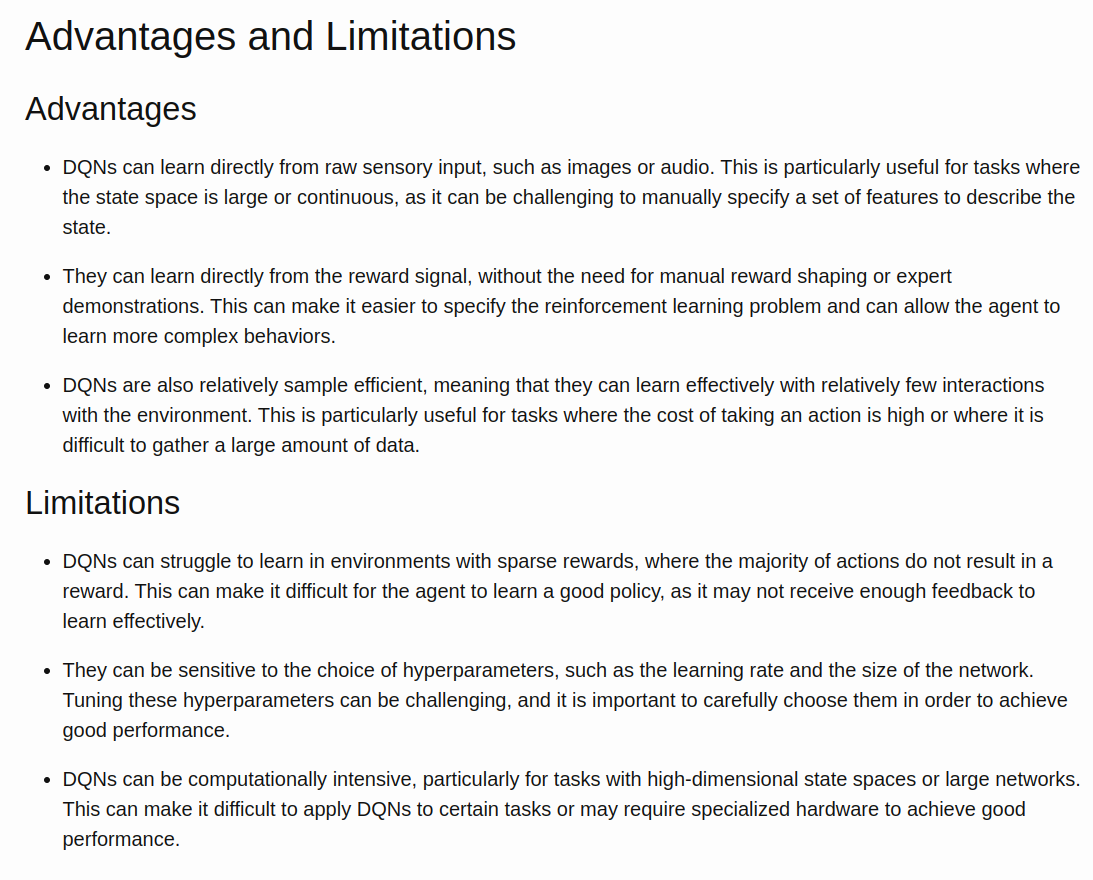

In [14]:
# Define the network architecture
class QNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super(QNetwork, self).__init__()

    self.fc1 = nn.Linear(state_size, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, action_size)

  def forward(self, x):
    x = T.relu(self.fc1(x))
    x = T.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [15]:
# define the replay buffer
class ReplayBuffer:
  def __init__(self, capacity):
    self.capacity = capacity
    self.buffer = []
    self.index = 0

  def push(self, state, action, reward, next_state, done):
    # if not enough fulfill the capacity, extend with None
    if len(self.buffer) < self.capacity:
      self.buffer.append(None)

    # storing the tuples of experiences
    self.buffer[self.index] = (state, action, reward, next_state, done)

    # writing buffer experiences like self-looping 
    self.index = (self.index + 1) % self.capacity

  def sample(self, batch_size):
    # randomly choose batches to training DQN (indices)
    batch = np.random.choice(len(self.buffer), batch_size, replace=False)
    states, actions, rewards, next_states, dones = [], [], [], [], []

    for i in batch:
      state, action, reward, next_state, done = self.buffer[i]
      states.append(state)
      actions.append(action)
      rewards.append(reward)
      next_states.append(next_state)
      dones.append(done)

    return (
      T.tensor(np.array(states)).float(),
      T.tensor(np.array(actions)).long(),
      T.tensor(np.array(rewards)).unsqueeze(1).float(),
      T.tensor(np.array(next_states)).float(),
      T.tensor(np.array(dones)).unsqueeze(1).int()
    )
  
  def __len__(self):
    return len(self.buffer)

In [22]:
# define the vanilla DQN agent
class DQNAgent:
  def __init__(self, state_size, action_size, seed, learning_rate=1e-3, capacity=1000000,
               discount_factor=0.99, update_every=4, batch_size=64):
    
    self.state_size = state_size
    self.action_size = action_size
    self.seed = seed
    self.learning_rate = learning_rate
    self.discount_factor = discount_factor
    self.update_every = update_every
    self.batch_size = batch_size
    self.steps = 0

    self.device = T.device("cuda" if T.cuda.is_available() else "cpu")

    self.qnetwork_local = QNetwork(state_size, action_size).to(self.device)
    self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)
    self.replay_buffer = ReplayBuffer(capacity)

  def step(self, state, action, reward, next_state, done):
    # save experience in replay buffer
    self.replay_buffer.push(state, action, reward, next_state, done)

    # learn every update_every steps
    self.steps += 1
    if self.steps % self.update_every == 0:
      if len(self.replay_buffer) > self.batch_size:

        # learn every 4 steps using the samples from buffer experience
        experiences = self.replay_buffer.sample(self.batch_size)
        self.learn(experiences)

  def act(self, state, eps=0.0):
    # device = T.device("cuda" if T.cuda.is_available() else "cpu")

    # epsilon-greedy action selection
    if random.random() > eps:
      # state = T.tensor(state).float().unsqueeze(0).to(device)
      state = T.tensor(state, dtype=T.float32, device=self.device).unsqueeze(0)
      self.qnetwork_local.eval()

      with T.no_grad():
        action_values = self.qnetwork_local(state)
      
      self.qnetwork_local.train()

      # return np.argmax(action_values.cpu().data.numpy())
      return int(action_values.argmax().cpu())
    else:
      return random.choice(np.arange(self.action_size))
    
  def learn(self, experiences):
    states, actions, rewards, next_states, dones = experiences

    states      = states.to(self.device)
    actions     = actions.to(self.device)
    rewards     = rewards.to(self.device)
    next_states = next_states.to(self.device)
    dones       = dones.to(self.device)

    # get max predicted Q values (for next states) from local model
    Q_targets_next = self.qnetwork_local(next_states).detach().max(1)[0].unsqueeze(1)

    # compute Q targets for current states
    Q_targets = rewards + (self.discount_factor * Q_targets_next * (1 - dones))

    # get expected Q values from local model
    Q_expected = self.qnetwork_local(states).gather(1, actions.view(-1, 1))

    # compute loss
    loss = F.mse_loss(Q_expected, Q_targets)

    # minimize the loss
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

Episode: 0
	Score: 42.0, Epsilon: 0.995
Episode: 1
	Score: 27.0, Epsilon: 0.990025
Episode: 2
	Score: 24.0, Epsilon: 0.985074875
Episode: 3
	Score: 20.0, Epsilon: 0.9801495006250001
Episode: 4
	Score: 25.0, Epsilon: 0.9752487531218751
Episode: 5
	Score: 25.0, Epsilon: 0.9703725093562657
Episode: 6
	Score: 40.0, Epsilon: 0.9655206468094844
Episode: 7
	Score: 34.0, Epsilon: 0.960693043575437
Episode: 8
	Score: 43.0, Epsilon: 0.9558895783575597
Episode: 9
	Score: 16.0, Epsilon: 0.9511101304657719
Episode: 10
	Score: 29.0, Epsilon: 0.946354579813443
Episode: 11
	Score: 39.0, Epsilon: 0.9416228069143757
Episode: 12
	Score: 21.0, Epsilon: 0.9369146928798039
Episode: 13
	Score: 14.0, Epsilon: 0.9322301194154049
Episode: 14
	Score: 16.0, Epsilon: 0.9275689688183278
Episode: 15
	Score: 19.0, Epsilon: 0.9229311239742362
Episode: 16
	Score: 23.0, Epsilon: 0.918316468354365
Episode: 17
	Score: 14.0, Epsilon: 0.9137248860125932
Episode: 18
	Score: 40.0, Epsilon: 0.9091562615825302
Episode: 19
	Scor

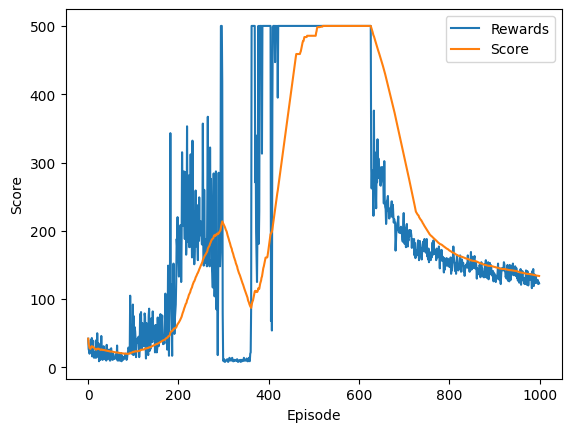

In [23]:
env = gym.make('CartPole-v1')

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

seed = 0

agent = DQNAgent(state_size, action_size, seed)

# set the # of episodes and the maximum number of steps per episode
num_episodes = 1000
max_steps = 1000

# set the exploration rate
eps = eps_state = 1.0
eps_end = 0.01
eps_decay = 0.995

# set rewards and scores lists
rewards = []
scores = []

for i_episode in range(num_episodes):
  print(f"Episode: {i_episode}")

  # init the env and the state
  state = env.reset()[0]
  score = 0

  # update the exploration rate
  eps = max(eps_end, eps_decay * eps)

  for t in range(max_steps):
    # select an action and take a step in the env
    action = agent.act(state, eps)
    next_state, reward, done, trunc, _ = env.step(action)

    # store the experience in the replay buffer and learn from it
    agent.step(state, action, reward, next_state, done)

    # update the state and the score
    state = next_state
    score += reward

    # break the loop if the episode is done
    if done or trunc:
      break
  
  print(f"\tScore: {score}, Epsilon: {eps}")

  # save the rewards and scores
  rewards.append(score)
  scores.append(np.mean(rewards[-100:]))

# close the env
env.close()

plt.ylabel("Score")
plt.xlabel("Episode")
plt.plot(range(len(rewards)), rewards)
plt.plot(range(len(rewards)), scores)
plt.legend(['Rewards', 'Score'])
plt.show()

In [18]:
# Define the network architecture
import torch

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.index = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.index] = (state, action, reward, next_state, done)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in batch:
            state, action, reward, next_state, done = self.buffer[i]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        return (
            torch.tensor(np.array(states)).float(),
            torch.tensor(np.array(actions)).long(),
            torch.tensor(np.array(rewards)).unsqueeze(1).float(),
            torch.tensor(np.array(next_states)).float(),
            torch.tensor(np.array(dones)).unsqueeze(1).int()
        )

    def __len__(self):
        return len(self.buffer)


# Define the Vanilla DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size, seed, learning_rate=1e-3, capacity=1000000,
                 discount_factor=0.99, update_every=4, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.update_every = update_every
        self.batch_size = batch_size
        self.steps = 0

        self.qnetwork_local = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer(capacity)

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay buffer
        self.replay_buffer.push(state, action, reward, next_state, done)

        # Learn every update_every steps
        self.steps += 1
        if self.steps % self.update_every == 0:
            if len(self.replay_buffer) > self.batch_size:
                experiences = self.replay_buffer.sample(self.batch_size)
                self.learn(experiences)

    def act(self, state, eps=0.0):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Epsilon-greedy action selection
        if random.random() > eps:
            state = torch.tensor(state).float().unsqueeze(0).to(device)
            self.qnetwork_local.eval()
            with torch.no_grad():
                action_values = self.qnetwork_local(state)
            self.qnetwork_local.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from local model
        Q_targets_next = self.qnetwork_local(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (self.discount_factor * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions.view(-1, 1))

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()

# 2. Dueling DQN